In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self,input):
        out = self.stn(input)

        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [6]:
from __future__ import print_function
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm

## 48 x 48 , 2304  1d dimension , save it in .csv file along with labels 
class Generate_data():
    def __init__(self, datapath):
        """
        Generate_data class
        Two methods to be used
        1-split_test
        2-save_images
        [Note] that you have to split the public and private from fer2013 file
        """
        self.data_path = datapath

    def split_test(self, test_filename = 'finaltest', val_filename= 'val'):
        """
        Helper function to split the validation and test data from general test file as it contains (Public test, Private test)
            params:-
                data_path = path to the folder that contains the test data file
        """
        csv_path = self.data_path +"/"+ 'test.csv'
        test = pd.read_csv(csv_path)
        validation_data = pd.DataFrame(test.iloc[:3589,:])
        test_data = pd.DataFrame(test.iloc[3589:,:])
        test_data.to_csv(self.data_path+"/"+test_filename+".csv")
        validation_data.to_csv(self.data_path+"/"+val_filename+".csv")
        print("Done splitting the test file into validation & final test file")

    def str_to_image(self, str_img = ' '):
        '''
        Convert string pixels from the csv file into image object
            params:- take an image string
            return :- return PIL image object
        '''
        imgarray_str = str_img.split(' ')
        imgarray = np.asarray(imgarray_str,dtype=np.uint8).reshape(48,48)
        return Image.fromarray(imgarray)

    def save_images(self, datatype='train'):
        '''
        save_images is a function responsible for saving images from data files e.g(train, test) in a desired folder
            params:-
            datatype= str e.g (train, val, finaltest)
        '''
        foldername= self.data_path+"/"+datatype
        csvfile_path= self.data_path+"/"+datatype+'.csv'
        if not os.path.exists(foldername):
            os.mkdir(foldername)

        data = pd.read_csv(csvfile_path)
        images = data['pixels'] #dataframe to series pandas
        numberofimages = images.shape[0]
        for index in tqdm(range(numberofimages)):
            img = self.str_to_image(images[index])
            img.save(os.path.join(foldername,'{}{}.jpg'.format(datatype,index)),'JPEG')
        print('Done saving {} data'.format((foldername)))

In [7]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Plain_Dataset(Dataset):
    def __init__(self,csv_file,img_dir,datatype,transform):
        '''
        Pytorch Dataset class
        params:-
                 csv_file : the path of the csv file    (train, validation, test)
                 img_dir  : the directory of the images (train, validation, test)
                 datatype : string for searching along the image_dir (train, val, test)
                 transform: pytorch transformation over the data
        return :-
                 image, labels
        '''
        self.csv_file = pd.read_csv(csv_file)
        self.lables = self.csv_file['emotion']
        self.img_dir = img_dir
        self.transform = transform
        self.datatype = datatype

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = Image.open(self.img_dir+self.datatype+str(idx)+'.jpg')
        lables = np.array(self.lables[idx])
        lables = torch.from_numpy(lables).long()

        if self.transform :
            img = self.transform(img)
        return img,lables

#Helper function
def eval_data_dataloader(csv_file,img_dir,datatype,sample_number,transform= None):
    '''
    Helper function used to evaluate the Dataset class
    params:-
            csv_file : the path of the csv file    (train, validation, test)
            img_dir  : the directory of the images (train, validation, test)
            datatype : string for searching along the image_dir (train, val, test)
            sample_number : any number from the data to be shown
    '''
    if transform is None :
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
    dataset = Plain_Dataset(csv_file=csv_file,img_dir = img_dir,datatype = datatype,transform = transform)

    label = dataset.__getitem__(sample_number)[1]
    print(label)
    imgg = dataset.__getitem__(sample_number)[0]
    imgnumpy = imgg.numpy()
    imgt = imgnumpy.squeeze()
    plt.imshow(imgt)
    plt.show()

In [62]:

# generate_dataset = Generate_data("C:/Users/1315/Desktop/DeepEmotion/data")
# generate_dataset.split_test()
# generate_dataset.save_images()
# generate_dataset.save_images('finaltest')
# generate_dataset.save_images('val')

In [9]:
from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

#from data_loaders import Plain_Dataset, eval_data_dataloader
#from deep_emotion import Deep_Emotion
#from generate_data import Generate_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def Train(epochs,train_loader,val_loader,criterion,optmizer,device):
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)

        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/len(train_dataset)
        train_acc = train_correct.double() / len(train_dataset)
        validation_loss =  validation_loss / len(val_dataset)
        val_acc = val_correct.double() / len(val_dataset)
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))

    torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    print("===================================Training Finished===================================")


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description="Configuration of setup and training process")
#     parser.add_argument('-s', '--setup', type=bool, help='setup the dataset for the first time')
#     parser.add_argument('-d', '--data', type=str,required= True,
#                                help='data folder that contains data files that downloaded from kaggle (train.csv and test.csv)')
#     parser.add_argument('-hparams', '--hyperparams', type=bool,
#                                help='True when changing the hyperparameters e.g (batch size, LR, num. of epochs)')
#     parser.add_argument('-e', '--epochs', type= int, help= 'number of epochs')
#     parser.add_argument('-lr', '--learning_rate', type= float, help= 'value of learning rate')
#     parser.add_argument('-bs', '--batch_size', type= int, help= 'training/validation batch size')
#     parser.add_argument('-t', '--train', type=bool, help='True when training')
#     args = parser.parse_args()

#     if args.setup :
#         generate_dataset = Generate_data(args.data)
#         generate_dataset.split_test()
#         generate_dataset.save_images()
#         generate_dataset.save_images('finaltest')
#         generate_dataset.save_images('val')

epochs = 500
lr = 0.005 
batchsize = 128

net = Deep_Emotion()
net.to(device)
print("Model archticture:",net)
traincsv_file = 'data'+'/'+'train.csv'
valcsv_file = 'data'+'/'+'val.csv'
train_img_dir = 'data'+'/'+'train/'
val_img_dir = 'data'+'/'+'val/'

transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train_dataset = Plain_Dataset(csv_file = traincsv_file, img_dir = train_img_dir, datatype = 'train',transform = transformation )
val_dataset = Plain_Dataset(csv_file = valcsv_file, img_dir = val_img_dir, datatype = 'val',transform = transformation )
train_loader = DataLoader(train_dataset,batch_size=batchsize, shuffle = True, num_workers=0)
val_loader = DataLoader(val_dataset,batch_size=batchsize, shuffle = True, num_workers=0)
criterion= nn.CrossEntropyLoss()
optmizer= optim.Adam(net.parameters(),lr= lr)
Train(epochs, train_loader, val_loader, criterion, optmizer, device) 

Model archticture: Deep_Emotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [64]:
torch.save(net.state_dict(),'DeepEmotion_train.pt')

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Deep_Emotion()
net.load_state_dict(torch.load('DeepEmotion_train.pt'))
net.to(device)
from torchsummary import summary
summary(net, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 42, 42]             400
         MaxPool2d-2            [-1, 8, 21, 21]               0
              ReLU-3            [-1, 8, 21, 21]               0
            Conv2d-4           [-1, 10, 17, 17]           2,010
         MaxPool2d-5             [-1, 10, 8, 8]               0
              ReLU-6             [-1, 10, 8, 8]               0
            Linear-7                   [-1, 32]          20,512
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10           [-1, 10, 46, 46]             100
           Conv2d-11           [-1, 10, 44, 44]             910
        MaxPool2d-12           [-1, 10, 22, 22]               0
           Conv2d-13           [-1, 10, 20, 20]             910
           Conv2d-14           [-1, 10,

In [7]:
import cv2 
import matplotlib.pyplot as plt

In [8]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [43]:
frame = cv2.imread('sample2.jpg')

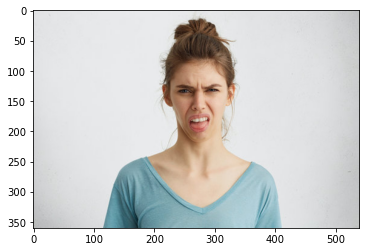

In [44]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [45]:
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

In [46]:
faces = faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    roi_gray=gray[y:y+h,x:x+w]
    roi_color = frame[y:y+h,x:x+w]
    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    facess = faceCascade.detectMultiScale(roi_color)
    if len(facess) == 0:
        print("Face not detected")
    else:
        for(ex,ey,ew,eh) in facess:
            face_roi = roi_color[ey:ey+eh,ex:ex+ew]

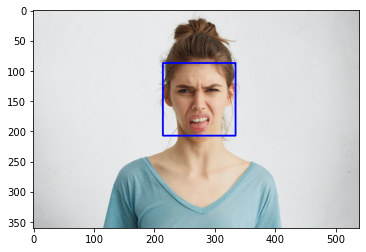

In [47]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

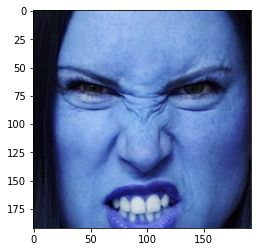

In [29]:
plt.imshow(face_roi)

In [48]:
gray=cv2.cvtColor(face_roi,cv2.COLOR_BGR2GRAY)

In [75]:
gray.shape

(147, 147)

In [49]:
final_image = cv2.resize(gray,(48,48))

In [77]:
final_image.shape

(48, 48)

In [51]:
final_image = np.expand_dims(final_image,axis=0)

In [34]:
final_image.shape

(1, 1, 48, 48)

In [52]:
final_image=final_image/255.0 ##normalization 

In [53]:
dataa = torch.from_numpy(final_image)

In [54]:
dataa=dataa.type(torch.FloatTensor)

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataa=dataa.to(device)


In [56]:
outputs = net(dataa)
pred = F.softmax(outputs,dim=1)

In [102]:
print(pred)

tensor([[6.0766e-03, 3.6404e-04, 1.3389e-01, 1.4499e-02, 1.2993e-02, 7.8252e-01,
         4.9662e-02]], device='cuda:0', grad_fn=<SoftmaxBackward>)


Angry


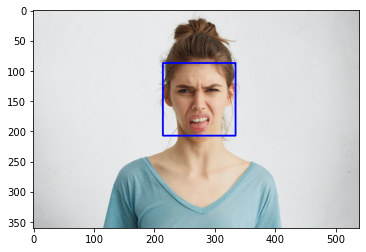

In [57]:
classes = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

print(classes[torch.argmax(pred)])
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))